# Diabet Prediction

**Ramzi Gallala** <br> 
ramzi.gallala@studio.unibo.it<br> <br>
Programmazione di applicazioni data intensive <br>
Laurea in Ingegneria e Scienze Informatiche  
DISI - Università di Bologna, Cesena

Citazioni: 
*   Stroke Preditction Dataset https://www.kaggle.com/alexteboul/diabetes-health-indicators-dataset


##Descrizione del problema e comprensione dei dati

*Questo progetto ha l'obiettivo di predire se un paziente ha il diabete o meno. Tutto questo analizzando le caratteristiche fisiche e lo stile di vita di alcuni pazienti.*

Vengono importate le librerie necessarie
- **NumPy** per lavorare agilmente con l'algebra lineare
- **Pandas** per gestire meglio i dati in formato tabellare
- **Seaborn** per disegnare i grafici (basata su **matplotlib**)
- **Urllib** per recuperare il dataset dalla repo github
- **Sklearn** per avere i modelli di classificazione
- **Imblearn** per applicare l'oversampling alla classe meno numerosa

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sb
import os.path
import math
from urllib.request import urlretrieve
from imblearn.over_sampling import SMOTE
import graphviz
from sklearn import tree
from sklearn.dummy import DummyClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

In [2]:
dataset_url = "https://bitbucket.org/ramzi_gallala/diabet_predictions/raw/5f469322bb510c7142bf7b09c0a44e2bfeae4bef/diabetes_012_health_indicators_BRFSS2015.csv"

if not os.path.exists("diabetes_012_health_indicators_BRFSS2015.csv"):
    urlretrieve(dataset_url, "diabetes_012_health_indicators_BRFSS2015.csv")

In [3]:
diabetes_dataset = pd.read_csv("diabetes_012_health_indicators_BRFSS2015.csv", sep=",")
diabetes_dataset.head(10)

Diabetes_012  HighBP  HighChol  CholCheck  ...  Sex   Age  Education  Income
0           0.0     1.0       1.0        1.0  ...  0.0   9.0        4.0     3.0
1           0.0     0.0       0.0        0.0  ...  0.0   7.0        6.0     1.0
2           0.0     1.0       1.0        1.0  ...  0.0   9.0        4.0     8.0
3           0.0     1.0       0.0        1.0  ...  0.0  11.0        3.0     6.0
4           0.0     1.0       1.0        1.0  ...  0.0  11.0        5.0     4.0
5           0.0     1.0       1.0        1.0  ...  1.0  10.0        6.0     8.0
6           0.0     1.0       0.0        1.0  ...  0.0   9.0        6.0     7.0
7           0.0     1.0       1.0        1.0  ...  0.0  11.0        4.0     4.0
8           2.0     1.0       1.0        1.0  ...  0.0   9.0        5.0     1.0
9           0.0     0.0       0.0        1.0  ...  1.0   8.0        4.0     3.0

[10 rows x 22 columns]

Nel nostro caso vista la quantità dei dati scegliamo di studiarne solamente 10000 su circa 254000. La scelta dei valori sarà presa in modo randomico.
Inoltre andremo a prendere i pre-diabetici e li metteremo nel gruppo dei diabetici cosi da effettuare una valutazione binaria. La scelta è stata presa riflettendo sul fatto che il nostro caso di studio cerca di stabilire i rischi che portano al diabete. 

In [4]:
diabetes_dataset = diabetes_dataset.sample(n = 10000)

In [5]:
diabetes_dataset['Diabetes_012'] = diabetes_dataset['Diabetes_012'].replace({1:0})
diabetes_dataset['Diabetes_012'] = diabetes_dataset['Diabetes_012'].replace({2:1})

###Comprensione delle feature

Descrizione:

1. **Diabetes_012**:[Intervallo] definisce se un paziente è diabetico(1.0) e non diabetico(0.0).
2. **HighBP**: [Nominale] pressione del paziente, può essere "alta(1.0)"o "bassa(0.0)"
3. **HighChol**: [Nominale] colesterolo del paziente, può essere "alta(1.0)"o "bassa(0.0)"
4. **CholCheck**: [Nominale] se il paziente ha fatto un controllo del colesterole negli ultimi 5 anni, può essere "averlo fatto(1.0)"o "non averlo fatto(0.0)"
5. **bmi**: [Intervallo] indica l'indice di massa corporea, si calcola come: $$ \frac{massa}{altezza^2} $$ 
6. **Smoker**: [Nominale] indica se il paziente nella sua vita ha fumato più di 100 sigarette, può essere "vero(1.0)"o "falso(0.0)"
7. **Stroke**: [Nominale] indica se il paziente ha avuto un ictus, assume valore 0 oppure 1
8. **HeartDiseaseorAttack**: [Nominale] indica se il paziente nella sua vita ha avuto malattie coronariche o infarti del miocardio, può essere "vero(1.0)"o "falso(0.0)"
9. **PhysActivity**: [Nominale] indica se il paziente ha fatto attività fisica negli ultimi 30 giorni (a parte il lavoro), assume valore 0 oppure 1
10. **Fruits**: [Nominale] indica se il paziente mangia frutta tutti i giorni, assume valore 0 oppure 1
11. **Veggies**: [Nominale] indica se il paziente mangia verdure tutti i giorni, assume valore 0 oppure 1
12. **HvyAlcoholConsump**: [Nominale] indica se il paziente è un "bevitore". Un bevitore è un uomo che beve più di 14 drink alla settimana oppure una donna che beve più di 7 drink alla settimana. Assume valore 0 oppure 1
13. **AnyHealthcare**: [Nominale] indica se il paziente ha un qualche tipo di assicurazione sulla salute, assume valore 0 oppure 1
14. **NoDocbcCost**: [Nominale] indica se il paziente ha avuto bisogno di un dottore ma non l'ha fatto a causa dei costi, assume valore 0 nel caso in cui non è successo  oppure 1 nel caso in cui non è andato a causa dei costi
15. **GenHlth**: [Intervallo] Quanto gli stessi pazienti credono di essere in salute. L'intervallo da 1 a 5, con valore 1 che significa eccellente e con valore 5 scarso 
16. **MentHlth**: [Intervallo] Quanti giorni durante gli ultimi 30 giorni il paziente ha avuto problemi mentali (stress, depressione, ect)
17. **PhysHlth**: [Intervallo] Quanti giorni durante gli ultimi 30 giorni il paziente ha avuto infortuni o malattie fisiche
18. **DiffWalk**: [Nominale] Indica se il paziente ha problemi ha camminare o fare le scale, assume valore 0 se non succede e valore 1 se succede
19. **Sex**: [Nominale] genere del paziente, assume valore 0 se femmina e valore 1 se maschio
20. **Age**: [Intervallo] età del paziente secondo la tabella _AGEG5YR (senza l'ultima categoria) che divide le età in 13 categorie. https://www.icpsr.umich.edu/web/NAHDAP/studies/34085/datasets/0001/variables/AGEG5YR?archive=NAHDAP
21. **Education**: [Intervallo] livello educativo del paziente secondo la tabella EDUCA (senza l'ultima categoria) che divide i gradi scolastici in 6 livelli. https://www.icpsr.umich.edu/web/NAHDAP/studies/34085/datasets/0001/variables/EDUCA?archive=
22. **Income**: [Intervallo] reddito del paziente secondo la tabella INCOME2 che divide le fascie di reddito in 8.


>- 1: Less than 10,000
>- 2: Less than 15,000
>- 3: Less than 20,000
>- 4: Less than 25,000
>- 5: Less than 35,000
>- 6: Less than 50,000
>- 7: Less than 75,000
>- 8: 75,000 or more

$\Rightarrow$ Siccome la variabile `Diabetes_012` da predire è discreta si tratta di un problema di classificazione (con due classi)


In [6]:
diabetes_dataset.describe()

Diabetes_012        HighBP  ...     Education        Income
count  10000.000000  10000.000000  ...  10000.000000  10000.000000
mean       0.136700      0.429200  ...      5.057700      6.080100
std        0.343548      0.494987  ...      0.983192      2.051854
min        0.000000      0.000000  ...      1.000000      1.000000
25%        0.000000      0.000000  ...      4.000000      5.000000
50%        0.000000      0.000000  ...      5.000000      7.000000
75%        0.000000      1.000000  ...      6.000000      8.000000
max        1.000000      1.000000  ...      6.000000      8.000000

[8 rows x 22 columns]

Con il metodo describe possiamo ottenere varie informazioni sulle feature presenti nel dataset:


* L'età media dei pazienti è circa tra i 55-59 anni, inoltre possiamo notare che comunque il 50% ha più di 55-59 anni
* La media dei valori del BMI assume valore 28, leggermente troppo alto in quanto una persona con peso regolare dovrebbe stare nell'intervallo [18;25].
* Quasi tutte le persone hanno dichiarato di aver praticato almeno una volta uno sport nell'ultimo mese, il che non è molto conforme a una popolazione in sovrappeso. Questo potrebbe dipendere dalla concezione di attività fisica per ogni paziente
* Inoltre notiamo che la media delle persone durante il mese ha avuto 3/4 giorni di problemi mentali e/o problemi fisici.
* Il tenore di vita è medio con un reddito minore di 50.000. Questa ci fa capire il dato sopra perché le persone possono permettersi cure sanitarie e quindi non far aggravare infortuni o patologie.

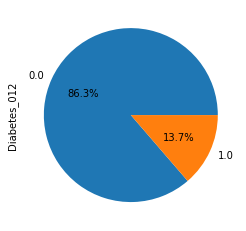

In [7]:
diabetes_dataset["Diabetes_012"].value_counts().plot.pie(autopct="%.1f%%");

Dal grafico a torta della feature `Diabetes_012` notiamo che le due classi sono estremamente sbilanciate, questo protrebbe creare problemi in seguito quindi nelle prossime sezioni verranno applicate tecniche come dare un peso diverso alle due classi oppure under/over -sampling di una delle due classi

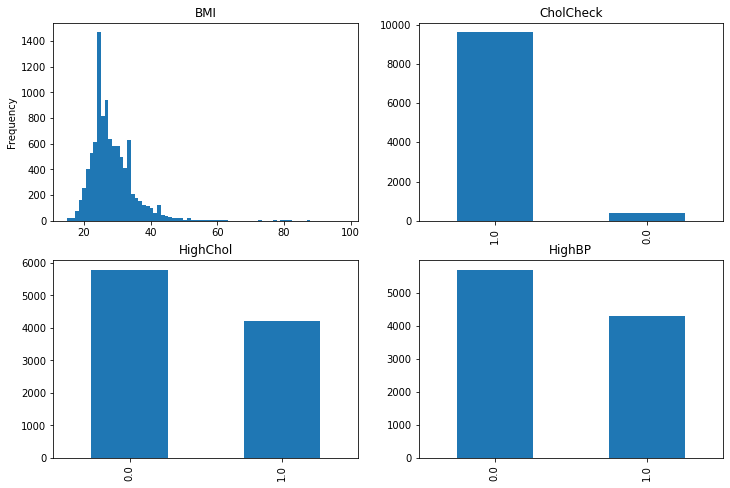

In [8]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.title("BMI")
diabetes_dataset["BMI"].plot.hist(bins=74);

plt.subplot(2,2,2)
plt.title("CholCheck")
diabetes_dataset["CholCheck"].value_counts().plot.bar();

plt.subplot(2,2,3)
plt.title("HighChol")
diabetes_dataset["HighChol"].value_counts().plot.bar();

plt.subplot(2,2,4)
plt.title("HighBP")
diabetes_dataset["HighBP"].value_counts().plot.bar();

Dai precedenti grafici per le distribuzioni delle feature osserviamo che:
* Il BMI è molto concentrato nell'intevallo [22;35]
* Inoltre osserviamo che circa più di una persona su due ha il colesterolo alto e/o la pressione alta. Questo rispecchia l'alta percentuale di pazienti sovrappeso.
* Infine osserviamo che molti pazienti hanno fatto un controllo del colesterolo. 

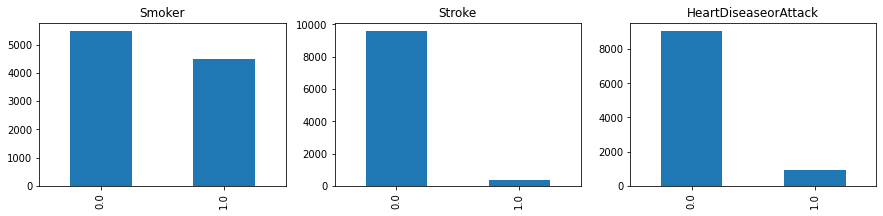

In [9]:
plt.figure(figsize=(15,3))
plt.subplot(1,3,1)
plt.title("Smoker")
diabetes_dataset["Smoker"].value_counts().plot.bar();

plt.subplot(1,3,2)
plt.title("Stroke")
diabetes_dataset["Stroke"].value_counts().plot.bar();

plt.subplot(1,3,3)
plt.title("HeartDiseaseorAttack")
diabetes_dataset["HeartDiseaseorAttack"].value_counts().plot.bar();



Da questi istogrammi possiamo notare che:


* C'è un'alta percentuale di fumatori.
* Il numero di ictus o problemi cardiaci durante la vita dei pazienti è basso.

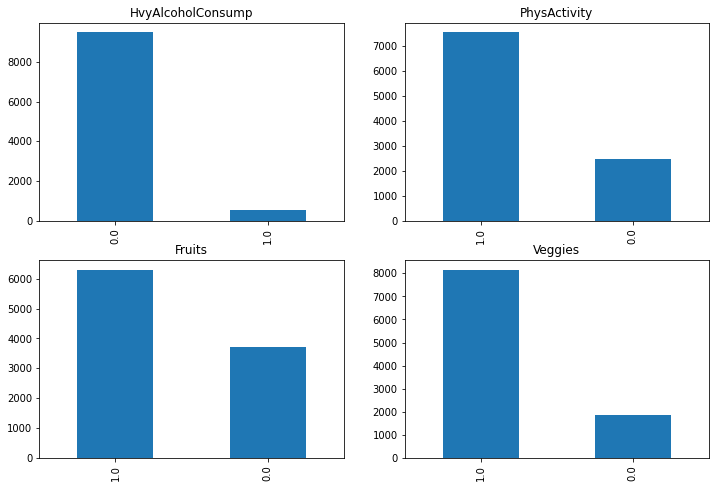

In [10]:
plt.figure(figsize=(12,8))

plt.subplot(2,2,1)
plt.title("HvyAlcoholConsump")
diabetes_dataset["HvyAlcoholConsump"].value_counts().plot.bar();

plt.subplot(2,2,2)
plt.title("PhysActivity")
diabetes_dataset["PhysActivity"].value_counts().plot.bar();

plt.subplot(2,2,3)
plt.title("Fruits")
diabetes_dataset["Fruits"].value_counts().plot.bar();

plt.subplot(2,2,4)
plt.title("Veggies")
diabetes_dataset["Veggies"].value_counts().plot.bar();

Da questi grafici notiamo che il campione di pazienti che stiamo studiando conduce una vita tendenziamente salutare. La maggior parte dei pazienti non consuma molto alcol e fa attività fisica. Inoltre, integra nella sua dieta frutta e verdura.

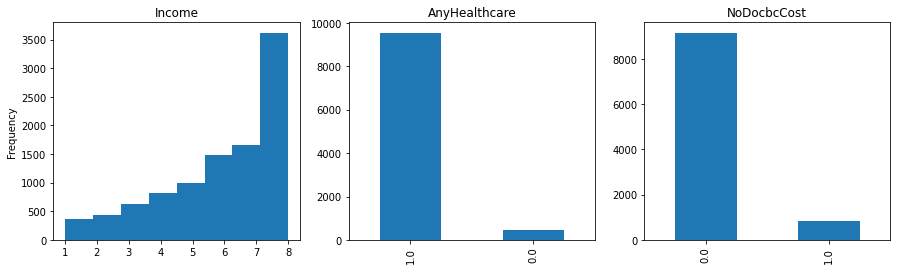

In [11]:
plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.title("Income")
diabetes_dataset["Income"].plot.hist(bins=8);

plt.subplot(1,3,2)
plt.title("AnyHealthcare")
diabetes_dataset["AnyHealthcare"].value_counts().plot.bar();

plt.subplot(1,3,3)
plt.title("NoDocbcCost")
diabetes_dataset["NoDocbcCost"].value_counts().plot.bar();

In questi tre grafici capiamo che i pazienti hanno circa un reddito tra 6 e 8. Questo tenore di vita, infatti, permette ha molti pazienti di avere un'assicurazione e quindi di non essersi mai privati del dottore quando ne necessitavano.

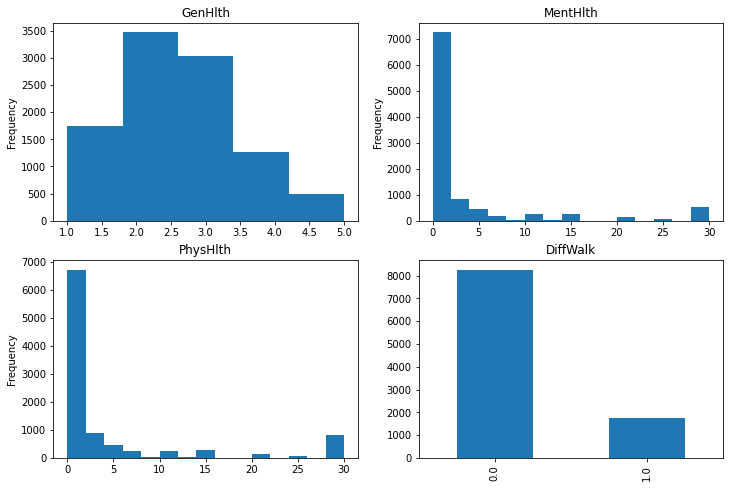

In [12]:
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.title("GenHlth")
diabetes_dataset["GenHlth"].plot.hist(bins=5);

plt.subplot(2,2,2)
plt.title("MentHlth")
diabetes_dataset["MentHlth"].plot.hist(bins=15);

plt.subplot(2,2,3)
plt.title("PhysHlth")
diabetes_dataset["PhysHlth"].plot.hist(bins=15);

plt.subplot(2,2,4)
plt.title("DiffWalk")
diabetes_dataset["DiffWalk"].value_counts().plot.bar();

Invece da questi quattro grafici osserviamo che le persone definiscono di stare in buona salute infatti durante gli ultimi 30 giorni hanno avuto pochi: infortuni o problemi mentali. Inoltre in pochi affermano di avere difficoltà nel camminare.

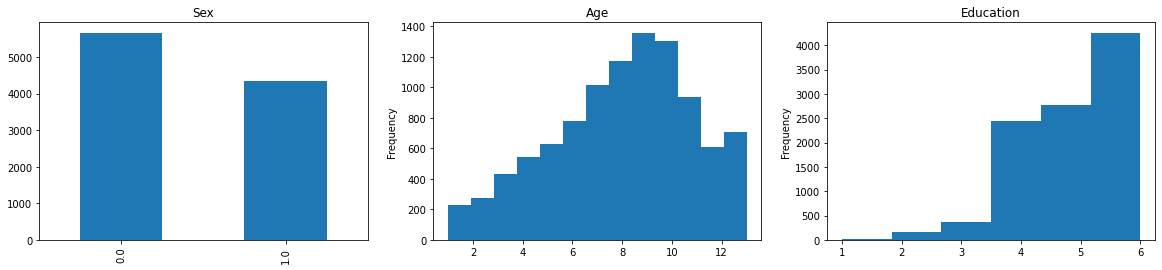

In [13]:
plt.figure(figsize=(20,4))
plt.subplot(1,3,1)
plt.title("Sex")
diabetes_dataset["Sex"].value_counts().plot.bar();

plt.subplot(1,3,2)
plt.title("Age")
diabetes_dataset["Age"].plot.hist(bins=13);

plt.subplot(1,3,3)
plt.title("Education")
diabetes_dataset["Education"].plot.hist(bins=6);

Infine da questi ultimi 3 grafici osserviamo:
* Il numero di pazienti donna è di poco maggiore rispetto al numero degli uomini.
* il livello di età è tra i 55 e i 69 anni
* L'educazione media è alta, tra 4 e 6 (High school fino alla laurea). Osserviamo il picco nei laureati.  

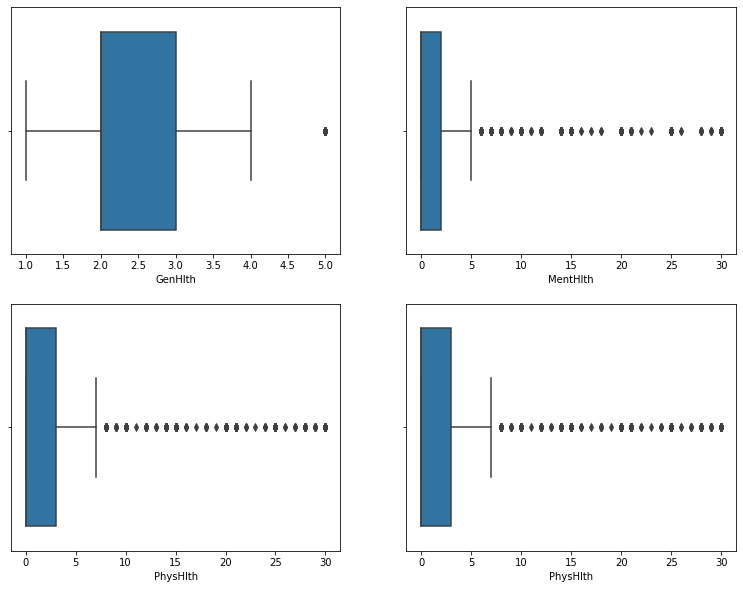

In [14]:
plt.figure(figsize=(13,10))
plt.subplot(2,2,1)

sb.boxplot(x="GenHlth", data=diabetes_dataset);

plt.subplot(2,2,2)

sb.boxplot(x="MentHlth", data=diabetes_dataset);

plt.subplot(2,2,3)

sb.boxplot(x="PhysHlth", data=diabetes_dataset);

plt.subplot(2,2,4)

sb.boxplot(x="PhysHlth", data=diabetes_dataset);


Dai grafici a dispersione sopra riportati notiamo che sono presenti pochi valori outliars

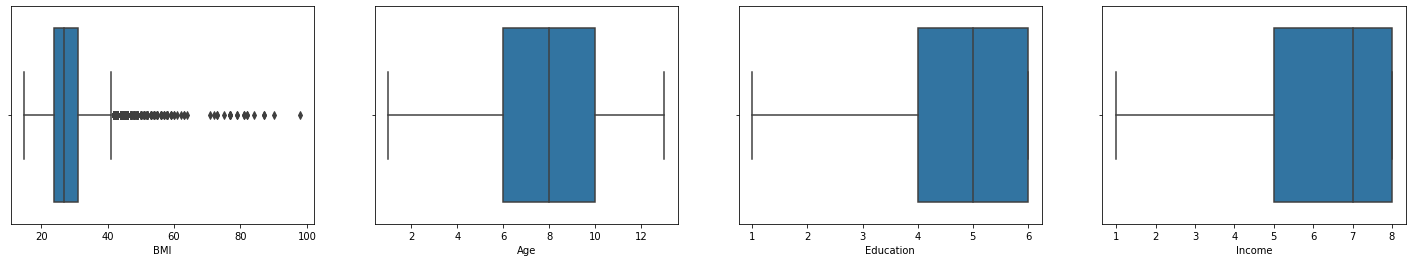

In [15]:
plt.figure(figsize=(25,4))

plt.subplot(1,4,1)
sb.boxplot(x="BMI", data=diabetes_dataset);

plt.subplot(1,4,2)
sb.boxplot(x="Age", data=diabetes_dataset);

plt.subplot(1,4,3)
sb.boxplot(x="Education", data=diabetes_dataset);

plt.subplot(1,4,4)
sb.boxplot(x="Income", data=diabetes_dataset);



Da questi ultimi grafici possiamo notare che la feature `BMI` sembra avere molti valori outlier, a primo impatto potremmo pensare di rimuoverne almeno una parte per non avere valori anomali, quindi facciamo un'analisi più approfondita per decidere se è il caso di farlo o no

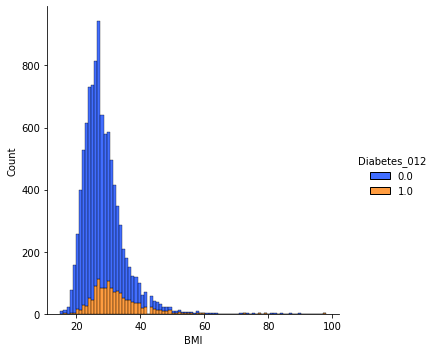

In [16]:

sb.displot(x='BMI', hue='Diabetes_012', data = diabetes_dataset, palette="bright",bins=86, multiple="stack");


In [17]:

diabetes_BMI43 = diabetes_dataset.loc[(diabetes_dataset.BMI >=43) & (diabetes_dataset.Diabetes_012 >=1.0), "Diabetes_012"].count()
diabetes_tot = diabetes_dataset.loc[(diabetes_dataset.BMI >=43), "Diabetes_012"].count()
diabetes_perc = diabetes_BMI43 / diabetes_tot
print(f"Abbiamo {diabetes_tot} con un valore BMI sopra 43, di cui {diabetes_BMI43} sono con il diabete, in percentuale sono quindi il {diabetes_perc:.1%}")

Abbiamo 335 con un valore BMI sopra 43, di cui 123 sono con il diabete, in percentuale sono quindi il 36.7%


In [18]:
diabetes_BMI43 = diabetes_dataset.loc[(diabetes_dataset.BMI <=43) & (diabetes_dataset.Diabetes_012 >=1.0), "Diabetes_012"].count()
diabetes_tot = diabetes_dataset.loc[(diabetes_dataset.BMI <=43), "Diabetes_012"].count()
diabetes_perc = diabetes_BMI43 / diabetes_tot
print(f"Abbiamo {diabetes_tot} con un valore BMI sotto 43, di cui {diabetes_BMI43} sono con il diabete, in percentuale sono quindi il {diabetes_perc:.1%}")

Abbiamo 9722 con un valore BMI sotto 43, di cui 1266 sono con il diabete, in percentuale sono quindi il 13.0%


Da questa ulteriore analisi possiamo quindi osservare due cose:


1.   Una buona fetta dei diabetici totali è presente in persone con un BMI non nella norma.
2.   Se consideriamo due frazioni distinte del dataset, nella prima sezione contenente i pazienti con un livello BMI inferiore a 43 abbiamo che i diabetici sono una piccola frazione dei casi totali mentre nella seconda sezione i diabetici sono una frazione molto più grande dei casi totali 

In virtù di questi risultati decidiamo di tenere anche i dati outlier per la feature `BMI`


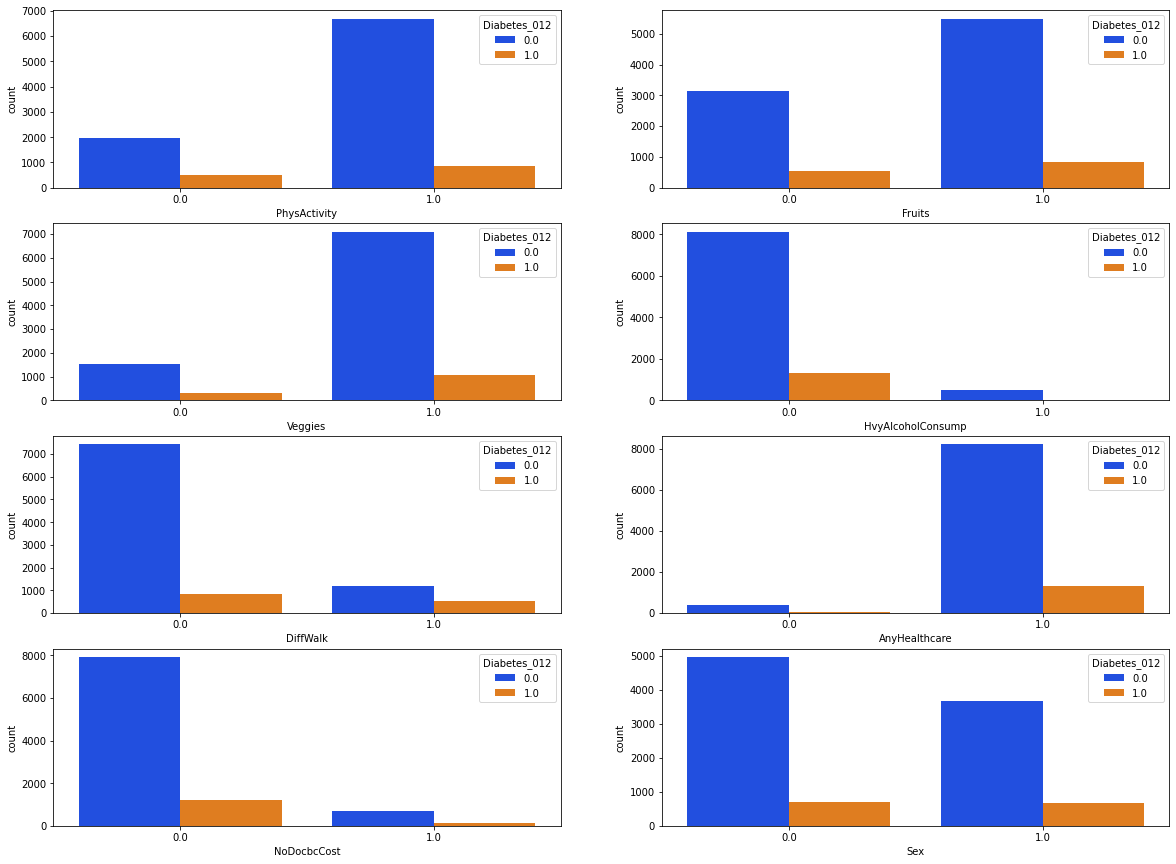

In [19]:
plt.figure(figsize=(20,15))

plt.subplot(4,2,1)
sb.countplot(x='PhysActivity', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

plt.subplot(4,2,2)
sb.countplot(x='Fruits', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

plt.subplot(4,2,3)
sb.countplot(x='Veggies', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

plt.subplot(4,2,4)
sb.countplot(x='HvyAlcoholConsump', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

plt.subplot(4,2,5)
sb.countplot(x='DiffWalk', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

plt.subplot(4,2,6)
sb.countplot(x='AnyHealthcare', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

plt.subplot(4,2,7)
sb.countplot(x='NoDocbcCost', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

plt.subplot(4,2,8)
sb.countplot(x='Sex', hue='Diabetes_012', data = diabetes_dataset, palette="bright");



I grafici sopra riportati ci indicano che:


*   Chi ha una cattiva alimentazione (frutta e verdura) e fa poca attività  fisica potrebbe avere il diabete o essere a rischio
*   problemi a camminnare tendono ad essere presenti in persone diabetiche 
*   Pochi pazienti bevitori presentano diabete
*   Il possedere una assicurazione influisce in modo lieve. Invece non potersi permettere un dottore influisce maggiormente sull'avere il diabete


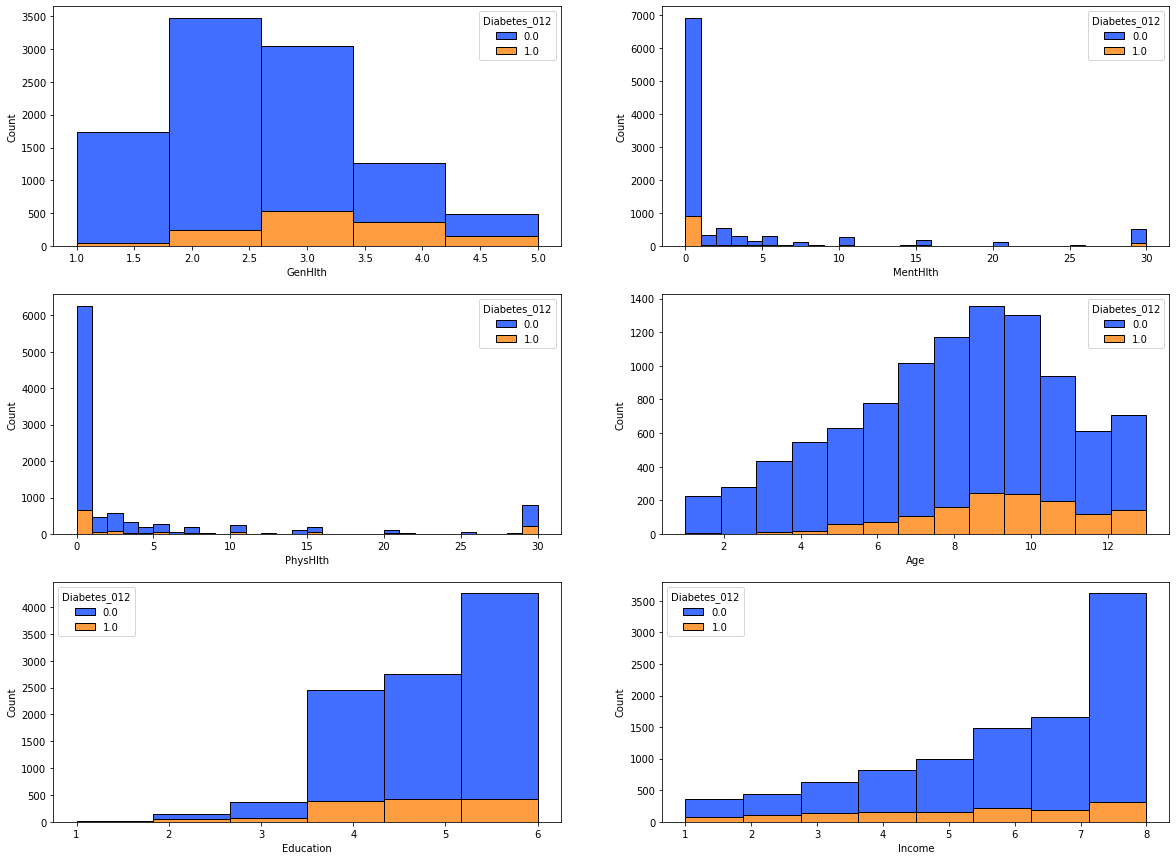

In [20]:
plt.figure(figsize=(20,15))

plt.subplot(3,2,1)
sb.histplot(x='GenHlth', hue='Diabetes_012', data = diabetes_dataset, palette="bright", bins=5, multiple="stack");

plt.subplot(3,2,2)
sb.histplot(x='MentHlth', hue='Diabetes_012', data = diabetes_dataset, palette="bright", bins=30, multiple="stack");

plt.subplot(3,2,3)
sb.histplot(x='PhysHlth', hue='Diabetes_012', data = diabetes_dataset, palette="bright", bins=30, multiple="stack");

plt.subplot(3,2,4)
sb.histplot(x='Age', hue='Diabetes_012', data = diabetes_dataset, palette="bright", bins=13, multiple="stack");

plt.subplot(3,2,5)
sb.histplot(x='Education', hue='Diabetes_012', data = diabetes_dataset, palette="bright", bins=6, multiple="stack");

plt.subplot(3,2,6)
sb.histplot(x='Income', hue='Diabetes_012', data = diabetes_dataset, palette="bright", bins=8, multiple="stack");



Notiamo quindi che:


*   Le persone che affermano di essere di scarsa salute hanno il diabete
*   I pazienti con un basso reddito tendono ad avere il diabete di più rispetto le persone con un reddito maggiore
*   L'educazione influisce in maniera minima al diabete. Cosi come problemi fisici e mentali
*   Le persone che tendono ad avere il diabete sono dai 70 anni in poi

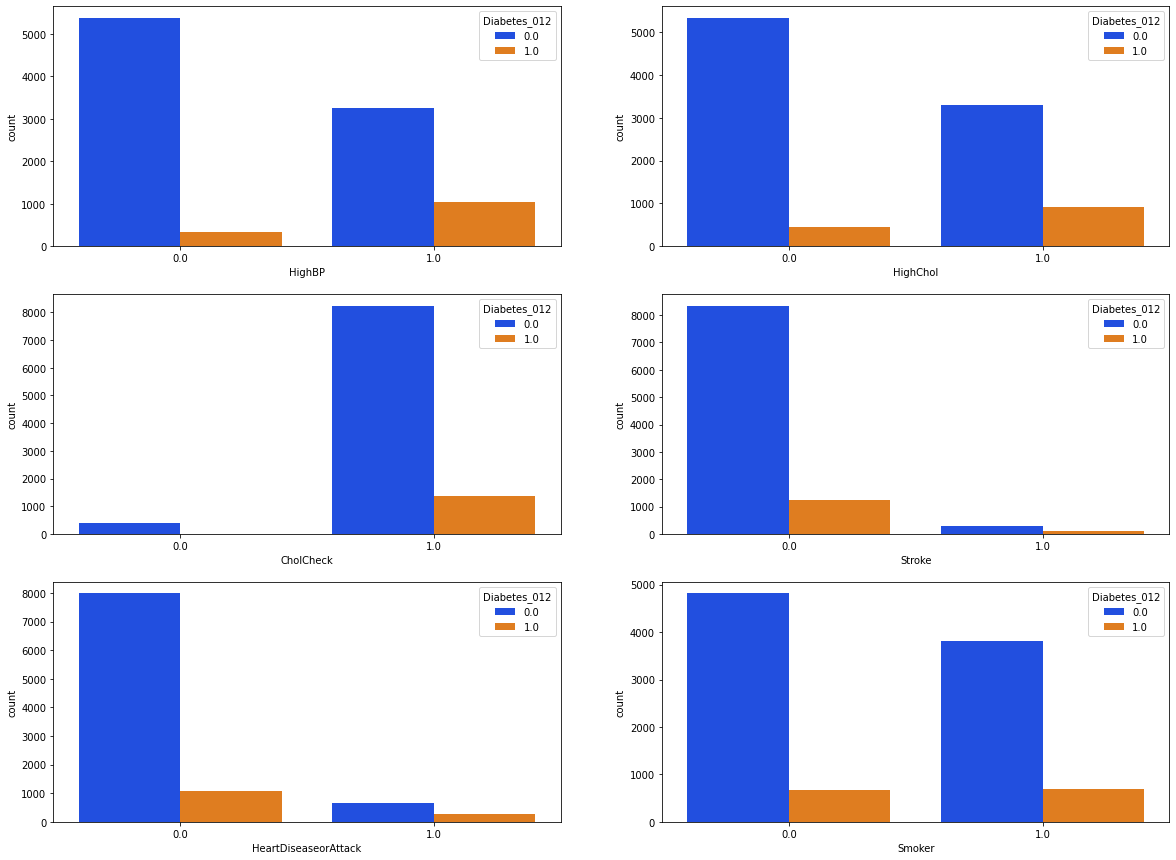

In [21]:
plt.figure(figsize=(20,15))

plt.subplot(3,2,1)
sb.countplot(x='HighBP', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

plt.subplot(3,2,2)
sb.countplot(x='HighChol', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

plt.subplot(3,2,3)
sb.countplot(x='CholCheck', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

plt.subplot(3,2,4)
sb.countplot(x='Stroke', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

plt.subplot(3,2,5)
sb.countplot(x='HeartDiseaseorAttack', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

plt.subplot(3,2,6)
sb.countplot(x='Smoker', hue='Diabetes_012', data = diabetes_dataset, palette="bright");

Infine da questi ultimi grafici osserviamo delle importanti correlazioni:
* La pressione alta influisce nella determinazione dei soggetti diabetici. Cosi come un colesterolo alto.
* La presenza di ictus è assocciato fortemente con l'essere diabetici. Cosi come infarti o malattie coronariche (HeartDiseaseorAttack)
* I pazienti diabetici tendenzialmente sono anche fumatori.


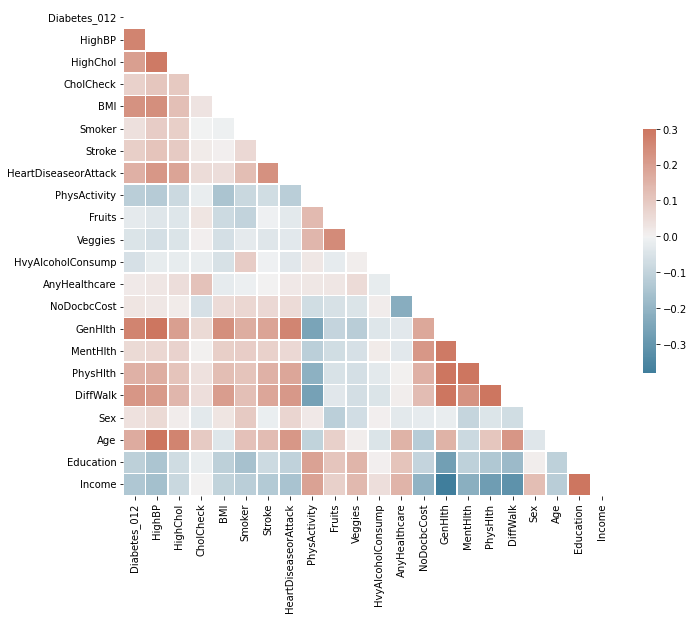

In [22]:
corr_matrix = diabetes_dataset.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sb.diverging_palette(230,20,as_cmap=True)
sb.heatmap(corr_matrix, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5});

#credits: https://seaborn.pydata.org/examples/many_pairwise_correlations.html?highlight=correlation%20matrix

Da questa matrice di correlazione possiamo osservare che:


*   La considerazione che gli stessi pazienti hanno di se stessi sembra che sia molto correlato: alla salute mentale, fisica ed alla pressione alta. 
*   Gli ictus sono correlati in modo più forte con una pressione alta e il voto che i pazienti si sono dati riguardo la propria salute. In minor modo è correlato con gli infortuni possibili del paziente (PhysActivity) 
*   Inoltre si è osservato che i problemi nel camminare sono connessi al valore BMI
*   Infine si puo anche notare che una pressione alta è associata ad un valore medio alto di colesterolo.

*Comunque i valori di correlazione non sono molto alti quindi probabilmente sarà necessario usare modelli con feature non lineari*

##Feature Engineering

Ora andremo ad applicare una tecnica di oversampling al dataset per ottenere un bilanciamento delle classi. 


In [23]:
st = SMOTE(random_state=42)
y = diabetes_dataset["Diabetes_012"]
X = diabetes_dataset.drop("Diabetes_012", axis=1)
X_res, y_res = st.fit_resample(X, y)

Dal seguente grafico notiamo che ora le classi sono bilanciate

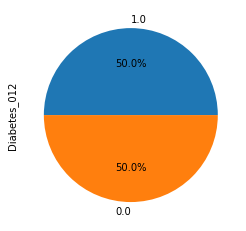

In [24]:
pd.value_counts(y_res).plot.pie(autopct="%.1f%%");

Andiamo ora a suddividere i dati in training set e validations set

In [25]:
X_train, X_val, y_train, y_val = train_test_split(
    X_res,y_res,
    test_size = 1/3,
    random_state = 42
)

Applichiamo una standardiddazione dei dati

In [26]:
scaler = StandardScaler()
X_train_D = scaler.fit_transform(X_train)
X_val_D = scaler.transform(X_val)

In tutti i modelli in cui verrà applicata la `Grid Search` useremo una divisione con la classe `StratifiedKFold` in modo da avere in ogni sub-fold la stessa distribuzione per i dati

La seguente funzione calcola l'intervallo di accuratezza per un modello di classificazione con confidenza al 95% dato l'f-1 score secondo la seguente formula: 
$$ p = \frac{f + \frac{z^2}{2N} \pm z \sqrt{\frac{f}{N} - \frac{f^2}{N} + \frac{z^2}{4N^2}  }  }{1+\frac{z^2}{N}}  $$


In [27]:
def accuracy_interval(f):
  N = len(y_val)
  n_min = f + ( 1.96**2/(2*N) - 1.96 * np.sqrt( (f/N) - (f**2/N) + (1.96**2/(4*N**2) ) ) ) 
  n_max = f + ( 1.96**2/(2*N) + 1.96 * np.sqrt( (f/N) - (f**2/N) + (1.96**2/(4*N**2) ) ) ) 
  d = 1 + (1.96**2 / N)
  e_min = n_min / d
  e_max = n_max / d
  return np.round(e_min,4), np.round(e_max,4)

Creo un dizionario vuoto in cui man mano inserirò i valori f1-score di ogni modello in modo da poter fare un confronto finale

In [28]:
accuracy = {}



##Logistic Regression

In [29]:
model = LogisticRegression(random_state=42, solver="saga")
model.fit(X_train_D, y_train)

LogisticRegression(random_state=42, solver='saga')

In [30]:
y_pred = model.predict(X_val_D)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

0.0   1.0
0.0  2051   849
1.0   615  2241

In [31]:
precision = precision_score(y_val, y_pred, average="macro")
recall = recall_score(y_val, y_pred, average="macro")
f1 = f1_score(y_val, y_pred, average="macro")

print(f"f1-score: {f1}, precision: {precision}, recall: {recall}")

f1-score: 0.7453792722356037, precision: 0.7472800238894675, recall: 0.7459526224282816


In [32]:
i = accuracy_interval(f1)
accuracy["Logistic Regression"] = i
print(i)

(0.734, 0.7565)


In [33]:
model = LogisticRegression(random_state=42, solver="saga")
parameters = {
    "penalty": ["l2", "l1", "elasticnet"],
    "C": [0.1, 1, 10],
    "l1_ratio": [0.2, 0.5]
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, parameters, cv=skf)

gs.fit(X_train_D, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  "(penalty={})".format(self.penalty)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:1479: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penal

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=LogisticRegression(random_state=42, solver='saga'),
             param_grid={'C': [0.1, 1, 10], 'l1_ratio': [0.2, 0.5],
                         'penalty': ['l2', 'l1', 'elasticnet']})

In [34]:
print(f'Best score: {round(gs.best_score_ * 100, 4):.4f}%')

Best score: 74.9869%


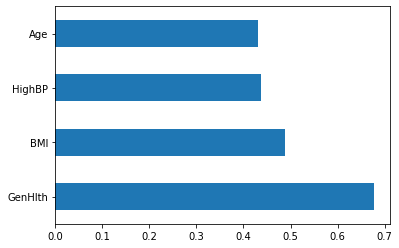

In [35]:
pc_imp = pd.Series(gs.best_estimator_.coef_[0], index=X.columns)
pc_imp.nlargest(4).plot(kind='barh');

Dopo la penalizzazione l1, che la GridSearch identifica come parametro migliore, notiamo che le caratteristiche più rilevanti sono:


*   Condizione di salute che dice di avere il paziente
*   l'età
*   Il livello di BMI
*   I valori alti di pressione sanguigna

In [36]:
cm = confusion_matrix(y_val,gs.predict(X_val_D))
tot = pd.DataFrame(cm,index=gs.classes_, columns=gs.classes_)

In [37]:
print(f'Il modello su {tot[1][1] + tot[0][1]} ha diagnosticato in modo esatto {tot[1][1]} casi di diabete e sbagliati {tot[0][1]}')
print(f'Il modello su {tot[1][0] + tot[0][0]} ha diagnosticato in modo esatto {tot[0][0]} casi di non diabete e sbagliati {tot[1][0]}')

Il modello su 2856 ha diagnosticato in modo esatto 2246 casi di diabete e sbagliati 610
Il modello su 2900 ha diagnosticato in modo esatto 2052 casi di non diabete e sbagliati 848


In [38]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

In [39]:
i = accuracy_interval(f1)
accuracy["Logistic regression with gs"] = i
print(i)

(0.734, 0.7565)


In [40]:
logisticregression_mse = mean_squared_error(y_val, y_pred)
print('MSE: {}'.format(logisticregression_mse))

MSE: 0.2543432939541348


##Perceptron

In [41]:
model = Perceptron(random_state=42)
model.fit(X_train_D, y_train)

Perceptron(random_state=42)

In [42]:
y_pred = model.predict(X_val_D)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=model.classes_, columns=model.classes_)

0.0   1.0
0.0  2166   734
1.0  1281  1575

In [43]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"f1-score: {f1}, precision: {precision}, recall: {recall}")

f1-score: 0.646200665573494, precision: 0.6283724978241949, recall: 0.7468965517241379


In [44]:
i = accuracy_interval(f1)
accuracy["Perceptron"] = i
print(i)

(0.6338, 0.6585)


Aggiungiamo GridSearch e CrossValidation

In [45]:
model = Perceptron(random_state=42)
parameters = {
    "penalty": [None, "l1", "l2", "elasticnet"],
    "alpha": np.logspace(-4, 0, 5),
    "tol": np.logspace(-9, 6, 6)
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, parameters, cv=skf)

gs.fit(X_train_D, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=Perceptron(random_state=42),
             param_grid={'alpha': array([1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00]),
                         'penalty': [None, 'l1', 'l2', 'elasticnet'],
                         'tol': array([1.e-09, 1.e-06, 1.e-03, 1.e+00, 1.e+03, 1.e+06])})

In [46]:
print(f'Best score: {round(gs.best_score_ * 100, 4):.4f}%')

Best score: 70.5560%


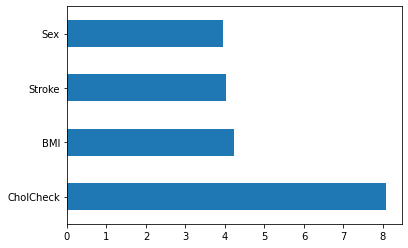

In [47]:
pc_imp = pd.Series(gs.best_estimator_.coef_[0], index=X.columns)
pc_imp.nlargest(4).plot(kind='barh');

In [48]:
y_pred = gs.predict(X_val_D)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

0.0   1.0
0.0  2002   898
1.0   721  2135

In [49]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"f1-score: {f1}, precision: {precision}, recall: {recall}")

f1-score: 0.7185780317218957, precision: 0.7352185089974294, recall: 0.6903448275862069


In [50]:
i = accuracy_interval(f1)
accuracy["Perceptron with gs"] = i
print(i)

(0.7068, 0.73)


In [51]:
perceptron_mse = mean_squared_error(y_val, y_pred)
print('MSE: {}'.format(perceptron_mse))

MSE: 0.28127171646977067


##Support Vector Machines

In [52]:
model = SVC()
parameters = {
    "kernel": ["rbf"],
    "C": np.logspace(-2, 0, 3)
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, parameters, cv=skf)

gs.fit(X_train_D, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(),
             param_grid={'C': array([0.01, 0.1 , 1.  ]), 'kernel': ['rbf']})

In [53]:
print(f'Best score: {round(gs.best_score_ * 100, 4):.4f}%')


Best score: 85.8471%


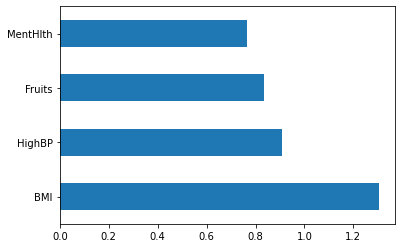

In [54]:
svm_imp = pd.Series(gs.best_estimator_.support_vectors_[0], index=X.columns)
svm_imp.nlargest(4).plot(kind='barh');

In [55]:
y_pred = gs.predict(X_val_D)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

0.0   1.0
0.0  2544   356
1.0   464  2392

In [56]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"f1-score: {f1}, precision: {precision}, recall: {recall}")

f1-score: 0.8574405456591844, precision: 0.8457446808510638, recall: 0.8772413793103448


In [57]:
i = accuracy_interval(f1)
accuracy["Support Vector Machines"] = i
print(i)

(0.8482, 0.8662)


In [58]:
svm_mse = mean_squared_error(y_val, y_pred)
print('MSE: {}'.format(svm_mse))

MSE: 0.14246004169562196


##Decision tree

I parametri che andiamo a testare nella grid search sono:
- `min_samples_split` che è il numero minimo di campioni che deve avere una foglia per poter essere splittata
- `min_samples_leaf` numero minimo di campioni per ogni foglia (i.e. se splittiamo un nodo questo split è valido solo se lascia in ogni foglia che crea almeno min_samples_leaf campioni)
- `max_depth` profondità massima che può raggiungere l'albero (con `None` cresce senza limiti su questo parametro)
- `max_features` il numero massimo di feature da considerare per ogni split

In [59]:
model = DecisionTreeClassifier(random_state=42)

num_features = X_train_D.shape[1]

parameters = {
             'min_samples_split': range(2, 4, 1),
             'min_samples_leaf': range(1, 4, 1), 
             'max_depth': [None] + [i for i in range(2, 7)],
             'max_features': range(2, num_features, 1)}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, parameters, cv=skf)

gs.fit(X_train_D, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'max_depth': [None, 2, 3, 4, 5, 6],
                         'max_features': range(2, 21),
                         'min_samples_leaf': range(1, 4),
                         'min_samples_split': range(2, 4)})

In [60]:
gs.best_score_

0.8781060986322281

In [61]:
y_pred = gs.predict(X_val_D)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

0.0   1.0
0.0  2600   300
1.0   394  2462

In [62]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"f1-score: {f1}, precision: {precision}, recall: {recall}")

f1-score: 0.8793608164556144, precision: 0.8684034736138945, recall: 0.896551724137931


In [63]:
i = accuracy_interval(f1)
accuracy["Decision tree"] = i
print(i)

(0.8707, 0.8875)


In [64]:
decisiontree_mse = mean_squared_error(y_val, y_pred)
print('MSE: {}'.format(decisiontree_mse))

MSE: 0.12056984016678249


###Visualizzazione dell'albero decisionale


Nei nodi troviamo:

- Il criterio con cui viene effettuato il taglio 


- Il parametro `gini` che indica la qualità della suddivisione, rappresenta la frequenza con cui un elemento scelto casualmente dall'insieme verrebbe etichettato in modo errato se fosse etichettato casualmente in base alla distribuzione delle etichette nel sottoinsieme, è calcolato come:
$$Gini = 1 - \sum_{i=1}^C p_i^2 $$

  $\Rightarrow$ Assume valore 0 quando tutte le istanze nel nodo hanno una stessa label

- Il parametro `samples` che indica la percentuale di campioni presenti in quel nodo
- Il parametro `value` che indica la percentuale di istanze per ogni classe

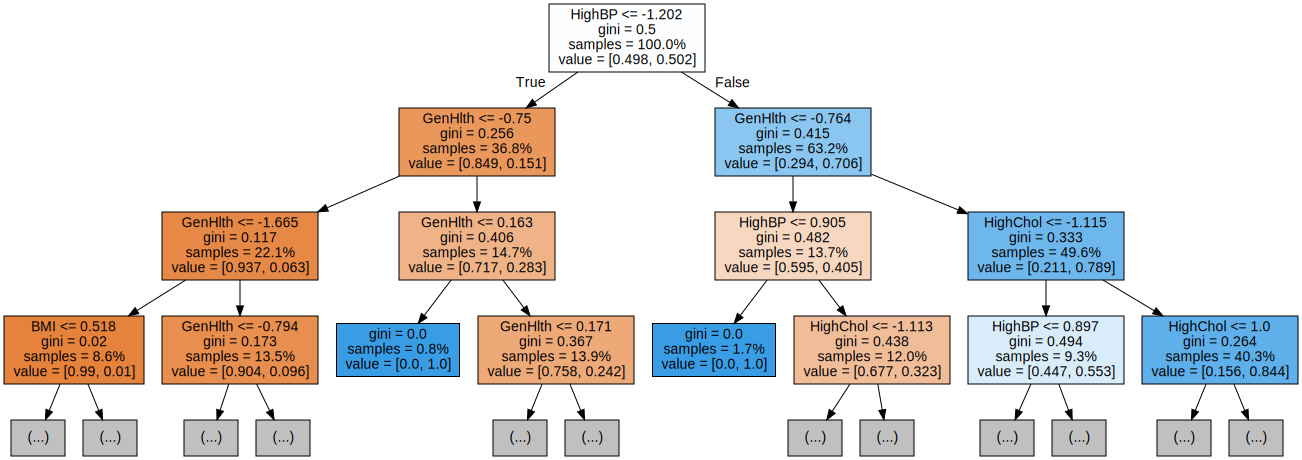

In [65]:
dot_data = tree.export_graphviz(gs.best_estimator_, out_file=None, feature_names=X.columns,  filled=True,
                                proportion=True, max_depth=3)

graph = graphviz.Source(dot_data, format="png") 
graph

##XGBoost

In [66]:
model = XGBClassifier(nthread=8, objective='binary:logistic')


parameters = {
    'eta': [0.002, 0.1, 0.5],
    'max_depth': [6],
    'n_estimators': [150, 300],
    'alpha': [0.0001, 0.001]
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, parameters, cv=skf)

gs.fit(X_train_D, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBClassifier(nthread=8),
             param_grid={'alpha': [0.0001, 0.001], 'eta': [0.002, 0.1, 0.5],
                         'max_depth': [6], 'n_estimators': [150, 300]})

In [67]:
gs.best_score_

0.915116872839318

In [68]:
y_pred = gs.predict(X_val_D)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

0.0   1.0
0.0  2763   137
1.0   358  2498

In [69]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")

print(f"f1-score: {f1}, precision: {precision}, recall: {recall}")

f1-score: 0.913820114392923, precision: 0.8852931752643384, recall: 0.9527586206896552


In [70]:
i = accuracy_interval(f1)
accuracy["XGBoost"] = i
print(i)

(0.9063, 0.9208)


In [71]:
xgboost_mse = mean_squared_error(y_val, y_pred)
print('MSE: {}'.format(decisiontree_mse))

MSE: 0.12056984016678249


###Confronto con un modello casuale

In [72]:
random = DummyClassifier(strategy="uniform", random_state=42)
random.fit(X_train_D, y_train)
y_pred = random.predict(X_val_D)
print(random.score(X_val_D, y_val))

0.49808895066018066


##Conclusioni

Riassunto di tutti i vari f1-score:

In [73]:
print (f"{'Model': <30} f1-score")
for k in accuracy.keys():
  print(f"{k: <30} {accuracy[k]}")

Model                          f1-score
Logistic Regression            (0.734, 0.7565)
Logistic regression with gs    (0.734, 0.7565)
Perceptron                     (0.6338, 0.6585)
Perceptron with gs             (0.7068, 0.73)
Support Vector Machines        (0.8482, 0.8662)
Decision tree                  (0.8707, 0.8875)
XGBoost                        (0.9063, 0.9208)


Visti i risultati ottenuti per l'indice *f1-score* possiamo dire che i migliori modelli sono:
- SVM con kernel RBF non lineare
- Decision tree
- XGBoost

Probabilmente la ragione per cui sono andati meglio i modelli non lineari è da reputarsi alla bassa correlazione tra le 21 features. L'utilizzo infatti di modelli non lineari permette di dividere meglio i dati.

Questo distinzione la possiamo notare con un modello SVM con kernel lineare. Il risultato sarà più basso (come si vede nell'esempio di seguito) 

In [74]:
model = SVC()
parameters = {
    "kernel": ["linear"]
}

skf = StratifiedKFold(3, shuffle=True, random_state=42)
gs = GridSearchCV(model, parameters, cv=skf)

gs.fit(X_train_D, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
             estimator=SVC(), param_grid={'kernel': ['linear']})

In [75]:
y_pred = gs.predict(X_val_D)
cm = confusion_matrix(y_val, y_pred)
pd.DataFrame(cm, index=gs.best_estimator_.classes_, columns=gs.best_estimator_.classes_)

0.0   1.0
0.0  1976   924
1.0   522  2334

In [76]:
precision = precision_score(y_val, y_pred, pos_label=0)
recall = recall_score(y_val, y_pred, pos_label=0)
f1 = f1_score(y_val, y_pred, average="macro")
print(f"f1-score: {f1}, precision: {precision}, recall: {recall}")

f1-score: 0.7478083148594634, precision: 0.7910328262610088, recall: 0.6813793103448276
